In [1]:
from train import *
from model import *
from helpers import *
from include import *

import os
import time
import plac
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
from IPython.display import clear_output

import numpy as np
from PIL import Image

import torch
from torch import nn, Tensor
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchvision.utils import make_grid
import torchvision.utils as vutils
import torchvision.datasets as dset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
else:
    dtype = torch.FloatTensor

num GPUs 2


In [2]:
# low shots
num_of_low_shots = 10
num_of_val = 24
image_size = 128

# Root directory for dataset
data_root = "./CelebA_data/celeba"

batch_size = 1
data_set = dset.ImageFolder(root=data_root,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor() ]))

train_set = IndexedDataset(torch.utils.data.Subset(data_set, range(len(data_set)-num_of_low_shots, len(data_set), 1)))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

# validate images
val_set = IndexedDataset(torch.utils.data.Subset(data_set, range(24, 44, 1)))
val_loader = torch.utils.data.DataLoader(val_set, shuffle=False, batch_size=1)

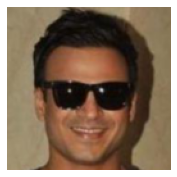

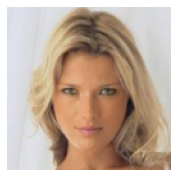

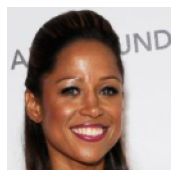

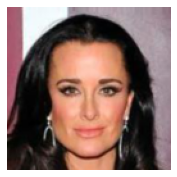

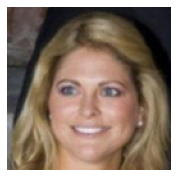

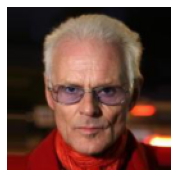

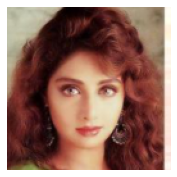

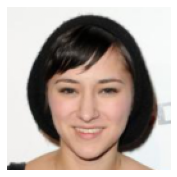

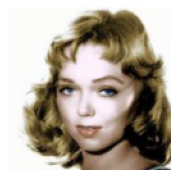

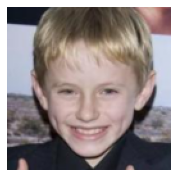

In [3]:
# low shots in the current training batch
Xi_train, _, _ = (next(iter(train_loader)))

for i, (Xi_train, _, _) in enumerate(train_loader):
    plt.figure(figsize=(3, 3))
    for i in range(len(Xi_train)):
        plt.subplot(1, len(Xi_train), i + 1)
        imgshow(Xi_train[i])
        plt.axis('off');

In [4]:
# one validate image
val_image, _, _ = val_set[13]
img_clean_var = val_image.view(-1, 3, 128, 128).to(device)

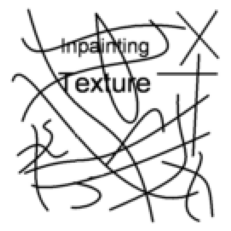

In [5]:
# given mask
output_depth = 3
img_mask_pil = Image.open('./mask.png')
mask_np = pil_to_np(img_mask_pil)
mask_np = np.array([mask_np[0,:,:] / np.max(mask_np) ] * output_depth)
mask_var = np_to_var(mask_np).type(dtype)
plt.imshow(var_to_np(mask_var).transpose(1, 2, 0))
plt.axis('off');

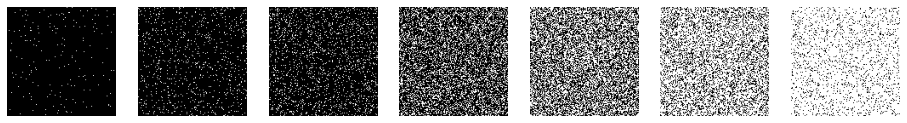

In [6]:
# random masks
ratios = np.array([0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9])
masks = torch.zeros(len(ratios), 3, image_size, image_size).to(device)

plt.figure(figsize=(16, 8))
for i in range(len(masks)):
    plt.subplot(1, len(masks), i + 1)
    tmp = torch.cuda.FloatTensor(1, 1, image_size, image_size).uniform_() < ratios[i]
    tmp = tmp.view(-1, 1, 128, 128)
    
    mask_np = var_to_np(tmp)
    mask_np = np.array([mask_np[0,:,:] / np.max(mask_np) ] * 3)
    masks[i] = np_to_var(mask_np).type(dtype)

    plt.imshow(mask_np.transpose(1, 2, 0))
    plt.axis('off');

(-0.5, 127.5, 127.5, -0.5)

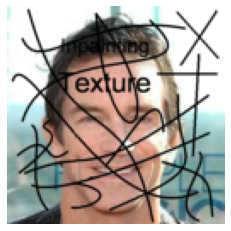

In [7]:
img_noisy_var = img_clean_var * mask_var
img_noisy_np = var_to_np(img_noisy_var)

# img_clean_var = val_image.view(1, 3, image_size, image_size).to(device)
# img_noisy_var = Variable(img_clean_var).to(device) * mask_var
imgshow(img_noisy_var)
plt.axis('off')

(-0.5, 127.5, 127.5, -0.5)

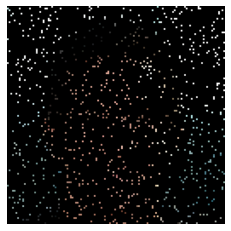

In [8]:
mask_var = masks[1].to(device)
img_noisy_var = img_clean_var * mask_var
img_noisy_np = var_to_np(img_noisy_var)

# img_clean_var = val_image.view(1, 3, image_size, image_size).to(device)
# img_noisy_var = Variable(img_clean_var).to(device) * mask_var
imgshow(img_noisy_var)
plt.axis('off')

In [9]:
num_channels = [64]*3
net = decodernw(num_channels_up=num_channels, upsample_first = True).type(dtype)

print("number of parameters: ", num_param(net))
print(net)
rnd = 500
numit = 10000
rn = 0.005

mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                        reg_noise_std=rn,
                        reg_noise_decayevery = rnd,
                        num_iter=numit,
                        LR=0.002,
                        img_noisy_var=img_noisy_var,
                        net=net,
                        img_clean_var=img_clean_var,
                        mask_var = mask_var,
                        find_best=True,
                        )

number of parameters:  17088
Sequential(
  (1): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (2): Upsample(scale_factor=2.0, mode=bilinear)
  (3): ReLU()
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (6): Upsample(scale_factor=2.0, mode=bilinear)
  (7): ReLU()
  (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (10): Upsample(scale_factor=2.0, mode=bilinear)
  (11): ReLU()
  (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(64, 64, kernel_size=(1, 1), stri

(-0.5, 127.5, 127.5, -0.5)

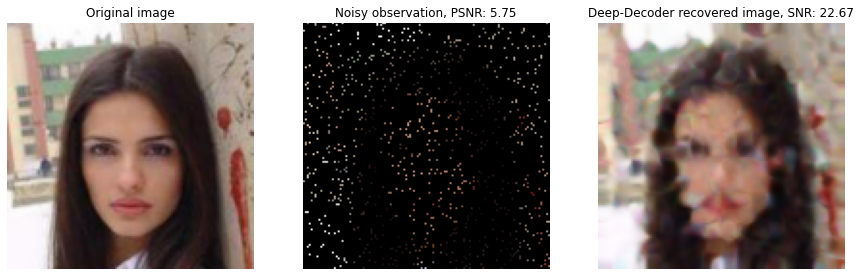

In [10]:
def myimgshow(plt,img):
    plt.imshow(np.clip(img.cpu().numpy()[0].transpose(1, 2, 0), 0, 1))
    
fig = plt.figure(figsize = (15,15)) 
    
ax1 = fig.add_subplot(131)
myimgshow(ax1, img_clean_var) 
ax1.set_title('Original image')
ax1.axis('off')


ax2 = fig.add_subplot(132)
myimgshow(ax2, img_noisy_var)
ax2.set_title( "Noisy observation, PSNR: %.2f" % psnr(img_clean_var.cpu().numpy(), img_noisy_var.cpu().numpy()) )
ax2.axis('off')

out_img_var = net( ni.type(dtype) ).detach()
ax3 = fig.add_subplot(133)
myimgshow(ax3, out_img_var)
ax3.set_title( "Deep-Decoder recovered image, SNR: %.2f" % psnr(img_clean_var.data.cpu().numpy(), out_img_var.data.cpu().numpy()[0]) ) 
ax3.axis('off')

(-0.5, 127.5, 127.5, -0.5)

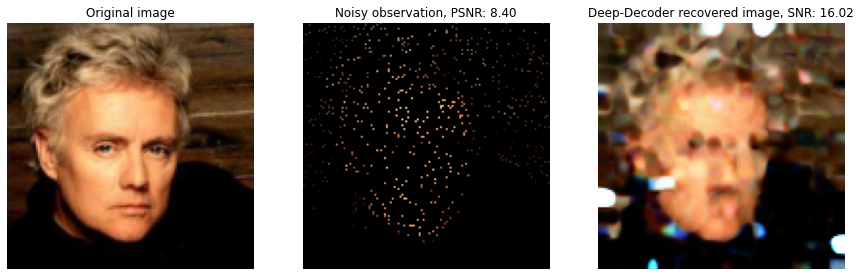

In [10]:
def myimgshow(plt,img):
    plt.imshow(np.clip(img.cpu().numpy()[0].transpose(1, 2, 0), 0, 1))
    
fig = plt.figure(figsize = (15,15)) 
    
ax1 = fig.add_subplot(131)
myimgshow(ax1, img_clean_var) 
ax1.set_title('Original image')
ax1.axis('off')


ax2 = fig.add_subplot(132)
myimgshow(ax2, img_noisy_var)
ax2.set_title( "Noisy observation, PSNR: %.2f" % psnr(img_clean_var.cpu().numpy(), img_noisy_var.cpu().numpy()) )
ax2.axis('off')

out_img_var = net( ni.type(dtype) ).detach()
ax3 = fig.add_subplot(133)
myimgshow(ax3, out_img_var)
ax3.set_title( "Deep-Decoder recovered image, SNR: %.2f" % psnr(img_clean_var.data.cpu().numpy(), out_img_var.data.cpu().numpy()[0]) ) 
ax3.axis('off')

(-0.5, 127.5, 127.5, -0.5)

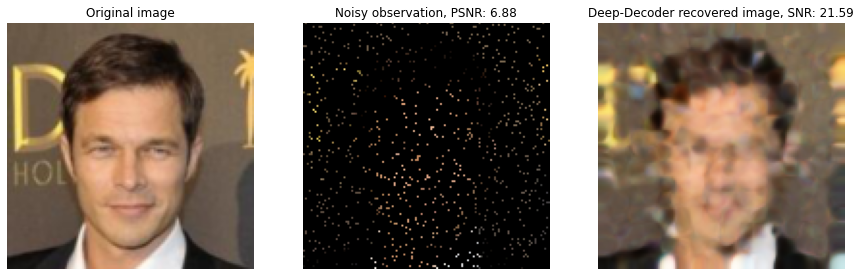

In [10]:
def myimgshow(plt,img):
    plt.imshow(np.clip(img.cpu().numpy()[0].transpose(1, 2, 0), 0, 1))
    
fig = plt.figure(figsize = (15,15)) 
    
ax1 = fig.add_subplot(131)
myimgshow(ax1, img_clean_var) 
ax1.set_title('Original image')
ax1.axis('off')


ax2 = fig.add_subplot(132)
myimgshow(ax2, img_noisy_var)
ax2.set_title( "Noisy observation, PSNR: %.2f" % psnr(img_clean_var.cpu().numpy(), img_noisy_var.cpu().numpy()) )
ax2.axis('off')

out_img_var = net( ni.type(dtype) ).detach()
ax3 = fig.add_subplot(133)
myimgshow(ax3, out_img_var)
ax3.set_title( "Deep-Decoder recovered image, SNR: %.2f" % psnr(img_clean_var.data.cpu().numpy(), out_img_var.data.cpu().numpy()[0]) ) 
ax3.axis('off')

(-0.5, 127.5, 127.5, -0.5)

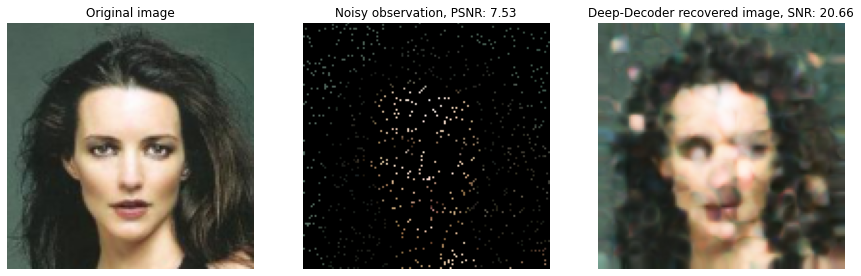

In [10]:
def myimgshow(plt,img):
    plt.imshow(np.clip(img.cpu().numpy()[0].transpose(1, 2, 0), 0, 1))
    
fig = plt.figure(figsize = (15,15)) 
    
ax1 = fig.add_subplot(131)
myimgshow(ax1, img_clean_var) 
ax1.set_title('Original image')
ax1.axis('off')


ax2 = fig.add_subplot(132)
myimgshow(ax2, img_noisy_var)
ax2.set_title( "Noisy observation, PSNR: %.2f" % psnr(img_clean_var.cpu().numpy(), img_noisy_var.cpu().numpy()) )
ax2.axis('off')

out_img_var = net( ni.type(dtype) ).detach()
ax3 = fig.add_subplot(133)
myimgshow(ax3, out_img_var)
ax3.set_title( "Deep-Decoder recovered image, SNR: %.2f" % psnr(img_clean_var.data.cpu().numpy(), out_img_var.data.cpu().numpy()[0]) ) 
ax3.axis('off')

(-0.5, 127.5, 127.5, -0.5)

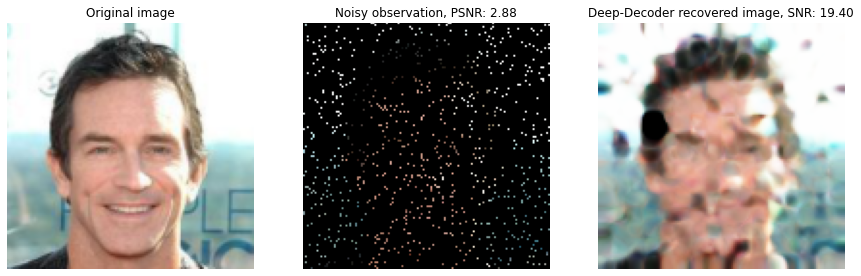

In [10]:
def myimgshow(plt,img):
    plt.imshow(np.clip(img.cpu().numpy()[0].transpose(1, 2, 0), 0, 1))
    
fig = plt.figure(figsize = (15,15)) 
    
ax1 = fig.add_subplot(131)
myimgshow(ax1, img_clean_var) 
ax1.set_title('Original image')
ax1.axis('off')


ax2 = fig.add_subplot(132)
myimgshow(ax2, img_noisy_var)
ax2.set_title( "Noisy observation, PSNR: %.2f" % psnr(img_clean_var.cpu().numpy(), img_noisy_var.cpu().numpy()) )
ax2.axis('off')

out_img_var = net( ni.type(dtype) ).detach()
ax3 = fig.add_subplot(133)
myimgshow(ax3, out_img_var)
ax3.set_title( "Deep-Decoder recovered image, SNR: %.2f" % psnr(img_clean_var.data.cpu().numpy(), out_img_var.data.cpu().numpy()[0]) ) 
ax3.axis('off')

In [9]:
code_dim = 16 # 16 * 16
k = 64 # number of channels
Z = np.random.normal(size=(len(train_set), k, code_dim, code_dim)).astype(np.float32)
Z = torch.tensor(Z, requires_grad=True).to(device) # Z[[0]].shape = [1, 64, 128, 128]

In [10]:
num_channels = [64]*3
rnd = 500
numit = 10000
rn = 0.005
p_net = decodernw(num_channels_up=num_channels, upsample_first = True).type(dtype)
print("number of parameters of p_net: ", num_param(p_net))

LV = LatentVariables(Z).to(device)
g = CombinedModel(LV, p_net).to(device)
g.apply(weight_init)
print("number of parameters of g: ", num_param(g))
print(g)

number of parameters of p_net:  17088
number of parameters of g:  180928
CombinedModel(
  (Z): LatentVariables()
  (Decoder): Sequential(
    (1): Sequential(
      (0): ReflectionPad2d((0, 0, 0, 0))
      (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (2): Upsample(scale_factor=2.0, mode=bilinear)
    (3): ReLU()
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Sequential(
      (0): ReflectionPad2d((0, 0, 0, 0))
      (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (6): Upsample(scale_factor=2.0, mode=bilinear)
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Sequential(
      (0): ReflectionPad2d((0, 0, 0, 0))
      (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (10): Upsample(scale_factor=2.0, mode=bilinear)
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [12]:
# prepare for pre-train
loss_fn = nn.MSELoss()

learning_rate = 1e-3
optimizer = torch.optim.Adam(g.parameters(), lr=learning_rate)

Xi_train, _, _ = (next(iter(train_loader)))
train_number = np.arange(0, len(train_set))
train_number

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [13]:
# pre-train
epoch_pre = 6000
g, Z = pre_train(epoch_pre, 
                 train_loader, 
                 g, 
                 Z,
                 train_number,
                 optimizer, 
                 p_net,
                  "./low_shots_celeb/checkpoint/p_deepdecoder0_10shots.pt")

Pre-train Epoch: 100 	 Average Loss: 0.006467
Pre-train Epoch: 200 	 Average Loss: 0.005322
Pre-train Epoch: 300 	 Average Loss: 0.001991
Pre-train Epoch: 400 	 Average Loss: 0.001698
Pre-train Epoch: 500 	 Average Loss: 0.001590
Pre-train Epoch: 600 	 Average Loss: 0.001586
Pre-train Epoch: 700 	 Average Loss: 0.001226
Pre-train Epoch: 800 	 Average Loss: 0.001373
Pre-train Epoch: 900 	 Average Loss: 0.001178
Pre-train Epoch: 1000 	 Average Loss: 0.000860
Pre-train Epoch: 1100 	 Average Loss: 0.001041
Pre-train Epoch: 1200 	 Average Loss: 0.001175
Pre-train Epoch: 1300 	 Average Loss: 0.001613
Pre-train Epoch: 1400 	 Average Loss: 0.001443
Pre-train Epoch: 1500 	 Average Loss: 0.001434
Pre-train Epoch: 1600 	 Average Loss: 0.001266
Pre-train Epoch: 1700 	 Average Loss: 0.000902
Pre-train Epoch: 1800 	 Average Loss: 0.000654
Pre-train Epoch: 1900 	 Average Loss: 0.000980
Pre-train Epoch: 2000 	 Average Loss: 0.000915
Pre-train Epoch: 2100 	 Average Loss: 0.000631
Pre-train Epoch: 2200 

In [14]:
# visual exam
final_output = torch.zeros((len(val_set), 3, 128, 128)).to(device)
final_z_dict = torch.zeros((len(val_set), 64, 16, 16)).to(device)

psnr_list = np.zeros(num_of_val)

epoch_for_train_z = 4000

num_channels = [64]*3

# load pre-trained decoder
train_decoder = decodernw(num_channels_up=num_channels, upsample_first = True).type(dtype)

if os.path.isfile("./low_shots_celeb/checkpoint/p_deepdecoder0_10shots.pt"):
    print("loading...")
    train_decoder.load_state_dict(torch.load("./low_shots_celeb/checkpoint/p_deepdecoder0_10shots.pt"))
    Z = torch.load("./low_shots_celeb/checkpoint/Z.pt")
else:
    train_decoder.apply(weight_init)

# initial z
target_z = np.reshape(np.mean(Z.data.cpu().numpy(), axis=0), (1, 64, 16, 16))
target_z = torch.tensor(target_z, requires_grad=True).to(device)

LV = LatentVariables(target_z).to(device)
train_g = CombinedModel(LV, train_decoder).to(device)

# train phase: train z to find z_hat
start_time = time.time()
target_z_hat, _ = train(epoch_for_train_z, 
                        img_noisy_var, 
                        train_g, 
                        train_decoder, 
                        target_z, 
                        joint_train=False,
                        learning_rate=5 * 1e-4,
                        save_path="./low_shots_celeb/checkpoint/current_checkpoint_train_z.pt",
                        mask=mask_var,
                        measure=None)

print("finding optimal z costs %s seconds..." % (time.time() - start_time))

loading...
finding optimal z costs 19.317755222320557 seconds...


In [15]:
# naive deep-decoder with warm start
rnd = 500
numit = 10000
rn = 0.005
num_channels = [64]*3

start_time = time.time()
mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                        reg_noise_std=rn,
                        reg_noise_decayevery = rnd,
                        num_iter=numit,
                        LR=0.001,
                        img_noisy_var=img_noisy_var,
                        net=train_decoder,
                        img_clean_var=img_clean_var,
                        mask_var = mask_var,
                        net_input = target_z_hat.data,
                        find_best=True,
                        )

final_output = net( ni.type(dtype) ).detach()
print("deep-decoder costs %s seconds..." % (time.time() - start_time))

input provided
optimize with adam 0.001
deep-decoder costs 77.74600911140442 seconds...loss 0.029690 Actual loss orig 0.029690  Noise Energy 0.513512 


(-0.5, 127.5, 127.5, -0.5)

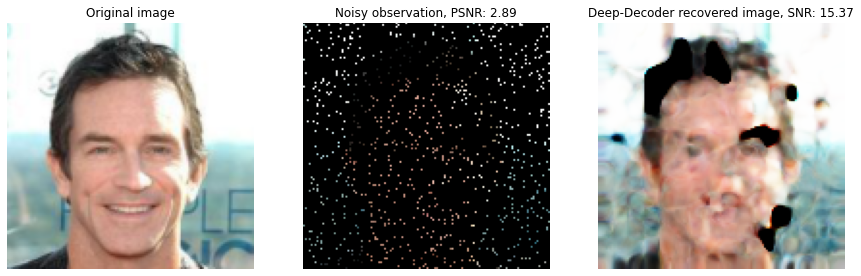

In [16]:
def myimgshow(plt,img):
    plt.imshow(np.clip(img.cpu().numpy()[0].transpose(1, 2, 0), 0, 1))
    
fig = plt.figure(figsize = (15,15)) 
    
ax1 = fig.add_subplot(131)
myimgshow(ax1, img_clean_var) 
ax1.set_title('Original image')
ax1.axis('off')

ax2 = fig.add_subplot(132)
myimgshow(ax2, img_noisy_var)
ax2.set_title( "Noisy observation, PSNR: %.2f" % psnr(img_clean_var.cpu().numpy(), img_noisy_var.cpu().numpy()) )
ax2.axis('off')

out_img_var = net( ni.type(dtype) ).detach()
ax3 = fig.add_subplot(133)
myimgshow(ax3, out_img_var)
ax3.set_title( "Deep-Decoder recovered image, SNR: %.2f" % psnr(img_clean_var.data.cpu().numpy(), out_img_var.data.cpu().numpy()[0]) ) 
ax3.axis('off')